<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Modeling2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install some of the dependencies

In [ ]:
!pip install fastdtw
!pip install pysptk      
!pip install gdown
!pip install pyworld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 20.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.2.0-cp37-cp37m-linux_x86_64.whl size=931331 sha256=854f7a0180e69a1c9dabc85c713e7eae85ec7829686f66c89aaec96550601f66
  Stored in directory: /root/.cache/pip/wheels/9a/70/a1/757bd6c0017f384831e6260a784f10ff6d7998a805719f9a2d
Successfully built pysptk
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 24.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to 

Import files from Google drive

In [ ]:
#the data
!gdown https://drive.google.com/uc?id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
#reconstruction module
!gdown https://drive.google.com/u/0/uc?id=1KYJD7INBZJ4Wip_ok6nGaJNGHZOCl8ra
#Melfiltebank applier
!gdown https://drive.google.com/u/0/uc?id=16XwS13GUAa7HuJv1Yi1XP6lQm0Gz42Ho

#extract the zip
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

#creating folders for the synthesized audiofiles for the best model and all model types
!mkdir synth_audio    #this one is for the best model, that will be trained and tested on all participants

#these 3 folders will be needed for the evaluation of each model type
!mkdir synth_audio_bn        #bottle neck
!mkdir synth_audio_dnn       #FC-DNN
!mkdir synth_audio_lstm      #LSTM

Downloading...
From: https://drive.google.com/uc?id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
To: /content/features.zip
100% 2.14G/2.14G [00:49<00:00, 42.9MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1KYJD7INBZJ4Wip_ok6nGaJNGHZOCl8ra
To: /content/reconstructWave.py
100% 3.02k/3.02k [00:00<00:00, 5.28MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=16XwS13GUAa7HuJv1Yi1XP6lQm0Gz42Ho
To: /content/MelFilterBank.py
100% 2.87k/2.87k [00:00<00:00, 4.13MB/s]


Necessary models and functions

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed
import numpy as np


#Bottleneck FC-DNN

def create_bottleneck_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(128, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(4, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model

#Normal FC-DNN

def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(200, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(50, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model


#LSTM/GRU Network

def create_LSTM_model(inputsize, outputsize):
  model = tf.keras.Sequential()
  model.add(LSTM(units=50, dropout=0.2, return_sequences=True, input_shape=(inputsize,1)))
  model.add(LSTM(units=50, dropout=0.2, return_sequences=True, input_shape=(inputsize,1)))
  model.add(Flatten())
  model.add(Dense(outputsize))
  return(model)


In [ ]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import numpy as np
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV files can be found
  '''

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    print("Processing -----------{}".format(subject))

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

    MCD_value = _logdb_const * float(s) / float(framesTot)

    print(f"MCD of {subject_ID}: {MCD_value}")


#Reconstructing the WAV file from the predicted mel-log spectrogram (Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [ ]:
#Setting seed
tf.keras.utils.set_random_seed(1234)

# 1.) One person model

### Optimizing the bottleneck FC-DNN structure for one person



In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile



data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 10
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#saving the losses across the iterations


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_bottleneck_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 5.67708, saving model to weights1.hdf5

Epoch 2: val_loss improved from 5.67708 to 3.32690, saving model to weights1.hdf5

Epoch 3: val_loss improved from 3.32690 to 2.60205, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.60205 to 2.42239, saving model to weights1.hdf5

Epoch 5: val_loss improved from 2.42239 to 2.22691, saving model to weights1.hdf5

Epoch 6: val_loss improved from 2.22691 to 2.19720, saving model to weights1.hdf5

Epoch 7: val_loss improved from 2.19720 to 2.01375, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 2.01375

Epoch 9: val_loss improved from 2.01375 to 1.78676, saving model to weights1.hdf5

Epoch 10: val_loss did not improve from 1.78676

Epoch 11: val_loss improved from 1.78676 to 1.63437, saving model to weights1.hdf5

Epoch 12: val_loss did not improve from 1.63437

Epoch 13: val_loss did not improve from 1.63437

Epoch 14: val_loss did not improve from 1.63437

Epoch 15: v

### Optimizing the normal FC-DNN structure for one person


In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 10
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # normal DNN model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_dnn_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_dnn/','sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 2.96020, saving model to weights1.hdf5

Epoch 2: val_loss improved from 2.96020 to 2.19236, saving model to weights1.hdf5

Epoch 3: val_loss improved from 2.19236 to 2.05884, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.05884 to 1.69374, saving model to weights1.hdf5

Epoch 5: val_loss improved from 1.69374 to 1.66186, saving model to weights1.hdf5

Epoch 6: val_loss improved from 1.66186 to 1.61506, saving model to weights1.hdf5

Epoch 7: val_loss improved from 1.61506 to 1.47246, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 1.47246

Epoch 9: val_loss improved from 1.47246 to 1.30716, saving model to weights1.hdf5

Epoch 10: val_loss improved from 1.30716 to 1.23067, saving model to weights1.hdf5

Epoch 11: val_loss improved from 1.23067 to 1.20288, saving model to weights1.hdf5

Epoch 12: val_loss improved from 1.20288 to 1.13376, saving model to weights1.hdf5

Epoch 13: val_loss did not improve from

### Optimizing the LSTM structure for one person

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 50
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):         
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0, shuffle=False)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # LSTM model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_LSTM_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the Autoencoder
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_lstm/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 3.54053, saving model to weights1.hdf5

Epoch 2: val_loss improved from 3.54053 to 3.03782, saving model to weights1.hdf5

Epoch 3: val_loss improved from 3.03782 to 2.66851, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.66851 to 2.36299, saving model to weights1.hdf5

Epoch 5: val_loss did not improve from 2.36299

Epoch 6: val_loss did not improve from 2.36299

Epoch 7: val_loss did not improve from 2.36299

Epoch 8: val_loss did not improve from 2.36299

Epoch 9: val_loss did not improve from 2.36299

Epoch 10: val_loss did not improve from 2.36299

Epoch 11: val_loss did not improve from 2.36299

Epoch 12: val_loss did not improve from 2.36299

Epoch 13: val_loss did not improve from 2.36299

Epoch 14: val_loss did not improve from 2.36299

Epoch 15: val_loss did not improve from 2.36299

Epoch 16: val_loss did not improve from 2.36299

Epoch 17: val_loss did not improve from 2.36299

Epoch 18: val_loss did not improve from

# 2.) MCD score evaluation

In [ ]:
import matplotlib.pyplot as plt
import librosa
import pyworld

In [ ]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [ ]:
orig_bn = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bn = load_wav('/content/synth_audio_dnn/sub-01_predicted.wav', 16000)

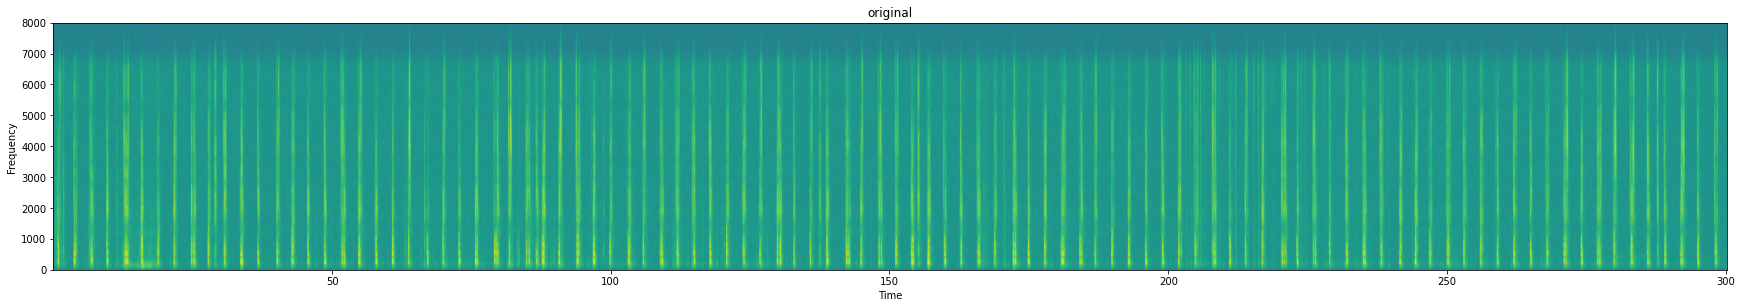

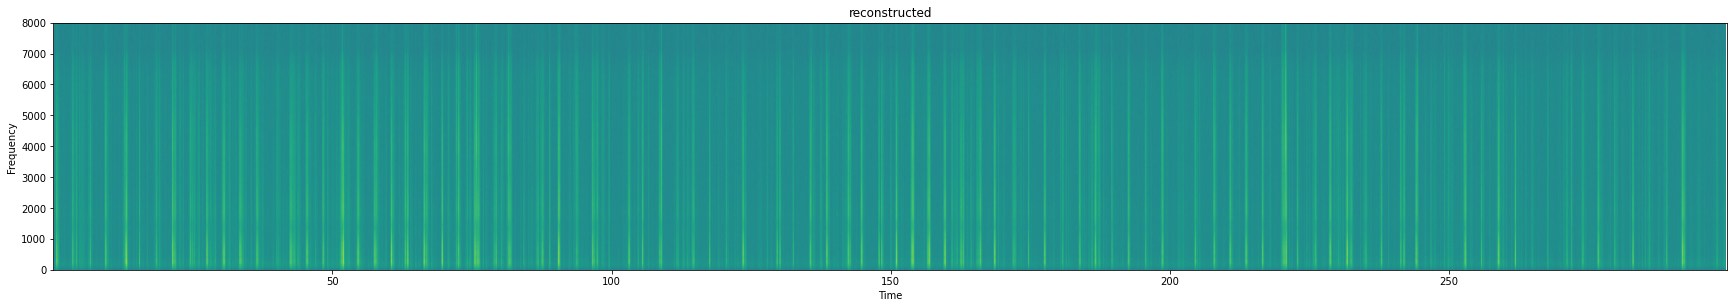

In [ ]:
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(orig_bn, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize = (30,10))

plt.subplot(212)
plt.specgram(rec_bn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

In [ ]:
compute_mcd('/content/synth_audio_bn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bn/sub-01_predicted.wav is ok!
MCD of sub-01: 7.410608335098642


In [ ]:
compute_mcd('/content/synth_audio_dnn/')

Processing -----------sub-01_predicted.wav


KeyboardInterrupt: ignored

In [ ]:
compute_mcd('/content/synth_audio_lstm/')

# 3.) Trying out the best configuration for every subject

In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile
##### MODELING ########

# So far, the best performance came from the normal DNN model

model = True

scores= []

if model == True:
    feat_path = r'/content/features'
    result_path = r'/content/synth_audio'
    pts = ['sub-%02d'%i for i in range(1,11)]

    winLength = 0.05
    frameshift = 0.01
    audiosr = 16000

    nfolds = 10
    kf = KFold(nfolds,shuffle=False)
    pca = PCA()
    numComps = 200
    

    for pNr, pt in enumerate(pts):
        
        
        #Load the data
        #Dimensions of these data vary depending on the subject
        spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))  
        data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))

        
        #Initialize an empty spectrogram to save the reconstruction to
        rec_spec = np.zeros(spectrogram.shape)
        #Save the correlation coefficients for each fold
        rs = np.zeros((nfolds,spectrogram.shape[1]))
        for k,(train, test) in enumerate(kf.split(data)):
          
            #Train, validation and test data
            X_train_temp = data[train,:]
            y_train_temp = spectrogram[train,:]
            X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
            X_test = data[test,:]
            y_test = spectrogram[test,:] # this one might not be needed
            
            #Standardization
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train[:] = scaler.transform(X_train)
            X_val[:] = scaler.transform(X_val)
            X_test[:] = scaler.transform(X_test)


            #Fit PCA to training data
            pca.fit(X_train)
            #Tranform data 
            X_train = np.dot(X_train, pca.components_[:numComps,:].T)
            X_val = np.dot(X_val, pca.components_[:numComps,:].T)
            X_test = np.dot(X_test, pca.components_[:numComps,:].T)

            # normal DNN model
            early_stopping=EarlyStopping(patience=25, verbose=0, min_delta=1e-5)
            checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=0)

            model = create_dnn_model(numComps, spectrogram.shape[1])
            model.compile(loss='mse', optimizer='adam', metrics=['mse'])
            model.fit(X_train, y_train, batch_size=64, 
                      epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                      callbacks=[checkpointer, early_stopping])
                    
            #predict with the best weights
            model.load_weights('weights1.hdf5')
            rec_spec[test, :] = model.predict(X_test, verbose=0)

            #Evaluate reconstruction of this fold
            for specBin in range(spectrogram.shape[1]):
                if np.any(np.isnan(rec_spec)):
                    print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
                r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
                rs[k,specBin] = r

        #Show evaluation result
        print('%s has mean correlation of %f' % (pt, np.mean(rs)))
        scores.append(np.mean(rs))


        #Make and save the synthesized audio
        reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
        wavfile.write(os.path.join('/content/synth_audio/',f'{pt}_predicted.wav'),int(audiosr),reconstructedWav)
        

In [ ]:
# MCD score for the subjects
compute_mcd('/content/synth_audio/')